# Results of white-box MIAs on the Purchase100 dataset

The models are trained using an MLP architecture referred to as MLP4 in the paper. 

The specification of this architecture is given in ```../configs/purchase100/mlp_small_dropout.ini```.

We load results for MIAs trained using different features (specified below as ```activations```, ```gradients```, or ```activations,gradients```), extracted from different layers (e.g., ```fc4``` which stands for the fourth fully connected layer). The features can be extracted from different types of shadow models, indicated in the ```attacker_accessess``` list below. We hope the naming to be self-explanatory. We refer you to ```shadow_modelling_attack.py``` for more details on the different types of shadow models. 

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.stats

In [6]:
attacker_accesses = ["aa-target_dataset",
    "aa-shadow_dataset_model_init",
    "aa-shadow_dataset",
    "aa-shadow_dataset-align-weight_sorting",
    "aa-shadow_dataset-align-bottom_up_weight_matching",
    "aa-shadow_dataset-align-top_down_activation_matching",
    "aa-shadow_dataset-align-top_down_weight_matching",
    "aa-shadow_dataset-align-bottom_up_correlation_matching",
    "aa-shadow_dataset-set-based"]

In [7]:
roc_results = {attacker_access: 
               {f : defaultdict(list) 
                for f in ['activations', 'gradients', 'activations,gradients']} 
               for attacker_access in attacker_accesses}

In [8]:
experiments_dir = '../experiments/purchase100/attack/generic-mlp-dropout_600,512,256,128,100/attack_results'

num_repetitions = 10

for features in ['activations', 'gradients', 'activations,gradients']:
    print(f'\nFeatures: {features} \n')
    if features == 'activations,gradients':
        target_layers =  ["fc4", "fc4-ia", "fc4-ia,fc3"]
    else:
        target_layers = ["fc4"]
    for attacker_access in attacker_accesses:
        print(f'\nAttacker access: {attacker_access}')
        results = {layer: {"test_acc": [], "test_auc": [], "best_test_acc": []} for layer in target_layers}
    
        for layer in target_layers:
            num_repetitions_found = 0
            for exp in range(num_repetitions):
                result_dir = os.path.join(experiments_dir, attacker_access, features, layer)
                saved_model_path = os.path.join(result_dir, f'exp_{exp}_model.pickle')
                if not os.path.exists(saved_model_path):
                    continue
                with open(saved_model_path, 'rb') as f:
                    saved_model = pickle.load(f)
                    if not saved_model['train_complete']:
                        continue
                    test_metrics = saved_model['test_metrics']
                test_acc = test_metrics['best_acc']
                test_auc = test_metrics['auc']
                results[layer]['test_auc'].append(test_auc)
                results[layer]['test_acc'].append(test_acc)
                num_repetitions_found += 1
                roc_results[attacker_access][features][layer].append( 
                    (test_metrics['fpr'], test_metrics['tpr']) )
            if num_repetitions_found == 0:
                continue
            mean_test_auc, std_test_auc = np.mean(results[layer]['test_auc']), np.std(results[layer]['test_auc'])
            mean_test_acc, std_test_acc = np.mean(results[layer]['test_acc']), np.std(results[layer]['test_acc'])
            h_test_auc =  std_test_auc * scipy.stats.t.ppf((1 + 0.95) / 2., num_repetitions_found-1) / (num_repetitions_found**0.5)
            print(f'Layer {layer}: {num_repetitions_found} experiments. ', 
                f'Test auc {mean_test_auc:.3f} ({h_test_auc:.3f}), best test acc: {mean_test_acc:.1%} ({std_test_acc:.1%})')


Features: activations 


Attacker access: aa-target_dataset
Layer fc4: 10 experiments.  Test auc 0.733 (0.010), best test acc: 71.0% (1.6%)

Attacker access: aa-shadow_dataset_model_init
Layer fc4: 10 experiments.  Test auc 0.736 (0.010), best test acc: 70.1% (1.9%)

Attacker access: aa-shadow_dataset
Layer fc4: 10 experiments.  Test auc 0.733 (0.012), best test acc: 70.3% (2.0%)

Attacker access: aa-shadow_dataset-align-weight_sorting

Attacker access: aa-shadow_dataset-align-bottom_up_weight_matching

Attacker access: aa-shadow_dataset-align-top_down_activation_matching

Attacker access: aa-shadow_dataset-align-top_down_weight_matching

Attacker access: aa-shadow_dataset-align-bottom_up_correlation_matching

Attacker access: aa-shadow_dataset-set-based

Features: gradients 


Attacker access: aa-target_dataset
Layer fc4: 10 experiments.  Test auc 0.734 (0.013), best test acc: 70.7% (1.9%)

Attacker access: aa-shadow_dataset_model_init
Layer fc4: 10 experiments.  Test auc 0.729 (0.01

In [9]:
features = 'activations,gradients'
print(f'\nFeatures: {features} \n')

for attacker_access in attacker_accesses:
    print(f'\nAttacker access: {attacker_access}')
    results = {layer: {"test_acc": [], "test_auc": [], "best_test_acc": []} for layer in target_layers}

    for layer in target_layers:
        num_repetitions_found = 0
        for exp in range(num_repetitions):
            result_dir = os.path.join(experiments_dir, attacker_access, features, layer)
            saved_model_path = os.path.join(result_dir, f'exp_{exp}_model.pickle')
            if not os.path.exists(saved_model_path):
                continue
            with open(saved_model_path, 'rb') as f:
                saved_model = pickle.load(f)
                if not saved_model['train_complete']:
                    continue
                test_metrics = saved_model['test_metrics']
            test_acc = test_metrics['best_acc']
            test_auc = test_metrics['auc']
            results[layer]['test_auc'].append(test_auc)
            results[layer]['test_acc'].append(test_acc)
            roc_results[attacker_access][features][layer].append( 
                (test_metrics['fpr'], test_metrics['tpr']) )
            num_repetitions_found += 1
        if num_repetitions_found == 0:
            continue
        mean_test_auc, std_test_auc = np.mean(results[layer]['test_auc']), np.std(results[layer]['test_auc'])
        mean_test_acc, std_test_acc = np.mean(results[layer]['test_acc']), np.std(results[layer]['test_acc'])
        #print(results[layer]['test_auc'])
        h_test_auc =  std_test_auc * scipy.stats.t.ppf((1 + 0.95) / 2., num_repetitions_found-1) / (num_repetitions_found**0.5)
        print(f'Layer {layer}: {num_repetitions_found} experiments. ', 
            f'Test auc {mean_test_auc:.3f} ({h_test_auc:.3f}), best test acc: {mean_test_acc:.1%} ({std_test_acc:.1%})')


Features: activations,gradients 


Attacker access: aa-target_dataset
Layer fc4: 10 experiments.  Test auc 0.739 (0.012), best test acc: 71.2% (1.5%)
Layer fc4-ia: 10 experiments.  Test auc 0.757 (0.013), best test acc: 72.0% (1.5%)

Attacker access: aa-shadow_dataset_model_init
Layer fc4: 10 experiments.  Test auc 0.732 (0.013), best test acc: 69.6% (2.4%)
Layer fc4-ia: 10 experiments.  Test auc 0.745 (0.012), best test acc: 70.7% (2.0%)

Attacker access: aa-shadow_dataset
Layer fc4: 10 experiments.  Test auc 0.728 (0.015), best test acc: 69.4% (2.5%)
Layer fc4-ia: 10 experiments.  Test auc 0.746 (0.011), best test acc: 70.6% (2.4%)

Attacker access: aa-shadow_dataset-align-weight_sorting
Layer fc4: 10 experiments.  Test auc 0.732 (0.015), best test acc: 69.7% (2.6%)
Layer fc4-ia: 10 experiments.  Test auc 0.745 (0.012), best test acc: 70.7% (2.0%)

Attacker access: aa-shadow_dataset-align-bottom_up_weight_matching
Layer fc4: 10 experiments.  Test auc 0.733 (0.015), best test acc: 69

## ROC curve

('aa-shadow_dataset', 'activations', 'fc4', '(S3) Black-box')
('aa-shadow_dataset_model_init', 'activations,gradients', 'fc4-ia', '(S2) White-box + same initiali-\nsation')
('aa-shadow_dataset', 'activations,gradients', 'fc4-ia', '(S3) White-box + no re-alignment')
('aa-shadow_dataset-align-weight_sorting', 'activations,gradients', 'fc4-ia', '(S4) White-box + weight \nsorting')
('aa-shadow_dataset-align-bottom_up_weight_matching', 'activations,gradients', 'fc4-ia', '(S5) White-box + bottom-up \nweight re-alignment')
('aa-shadow_dataset-align-top_down_weight_matching', 'activations,gradients', 'fc4-ia', '(S6) White-box + top-down \nweight re-alignment')
('aa-shadow_dataset-align-top_down_activation_matching', 'activations,gradients', 'fc4-ia', '(S7) White-box + activation \nre-alignment')
('aa-shadow_dataset-align-bottom_up_correlation_matching', 'activations,gradients', 'fc4-ia', '(S8) White-box + correlation \nre-alignment')


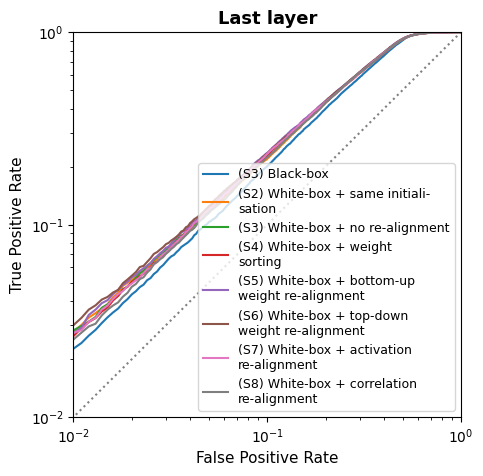

In [10]:
from confidence_interval import ci_roc_curve

white_box_layers, title = ('fc4-ia', 'Last layer')

attacks = [('aa-shadow_dataset', 'activations', 'fc4', 
            '(S3) Black-box'),
        ('aa-shadow_dataset_model_init', 'activations,gradients', white_box_layers, 
         '(S2) White-box + same initiali-\nsation'),
        ('aa-shadow_dataset', 'activations,gradients', white_box_layers, 
         '(S3) White-box + no re-alignment'),
        ('aa-shadow_dataset-align-weight_sorting', 'activations,gradients', white_box_layers, 
         '(S4) White-box + weight \nsorting'),
        ('aa-shadow_dataset-align-bottom_up_weight_matching', 'activations,gradients', white_box_layers, 
         '(S5) White-box + bottom-up \nweight re-alignment'),
        ('aa-shadow_dataset-align-top_down_weight_matching', 'activations,gradients', white_box_layers, 
         '(S6) White-box + top-down \nweight re-alignment'),
        ('aa-shadow_dataset-align-top_down_activation_matching', 'activations,gradients', white_box_layers, 
         '(S7) White-box + activation \nre-alignment'),
        ('aa-shadow_dataset-align-bottom_up_correlation_matching', 'activations,gradients', white_box_layers, 
         '(S8) White-box + correlation \nre-alignment')]

base_fpr = np.linspace(0, 1, 1001)

fig, ax = plt.subplots(figsize=(5, 5))

for attack in attacks:
    attacker_access, features, layers, label = attack
    print(attack)
    fprs, tprs = zip(*roc_results[attacker_access][features][layers])
    mean_tpr, lower_tpr, upper_tpr = ci_roc_curve(fprs, tprs, base_fpr)
    ax.plot(base_fpr, mean_tpr, label=label)

ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='gray', ls=':')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-2, 1)
ax.set_ylim(1e-2, 1)
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.legend(fontsize=9, loc='lower right')
plt.title(title, fontweight='bold', fontsize=13)
plt.savefig(f'../notebooks/plots/roc_purchase100_{white_box_layers}.pdf', bbox_inches='tight')
plt.show()
plt.close()